# MonthlyIncome は数値変換を行い、正規分布に近づける

In [50]:
# import os
# os.chdir('../../')

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scr.util import *

In [52]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.pipeline import Pipeline

In [53]:
df_train = pd.read_csv('data/null_survey/train_age_ok.csv')
df_test = pd.read_csv('data/null_survey/test_age_ok.csv')

In [54]:
df_train.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              56
ProdTaken                   0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [55]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome              49
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [56]:
# MonthlyIncome を正規分布に近づける
df_train['MonthlyIncome'] = np.log1p(df_train['MonthlyIncome'])
df_test['MonthlyIncome'] = np.log1p(df_test['MonthlyIncome'])

In [57]:
df_train['MonthlyIncome'].isna().sum()

56

In [58]:
df_test['MonthlyIncome'].isna().sum()

49

In [59]:
df_train['MonthlyIncome']

0       12.444719
1       12.910348
2       12.535901
3       12.697122
4       12.462403
          ...    
3484    12.464201
3485    12.470036
3486    12.667732
3487    13.176683
3488    12.536063
Name: MonthlyIncome, Length: 3489, dtype: float64

In [60]:
df_test['MonthlyIncome']

0       13.116247
1       12.611541
2       12.468441
3       12.467960
4       12.501838
          ...    
3484    12.475493
3485    12.765034
3486    12.506181
3487    12.515141
3488    12.928283
Name: MonthlyIncome, Length: 3489, dtype: float64

# 今回調査する欠損値：Age, DurationOfPitch, NumberOfTrips, *MonthlyIncome*

# MonthlyIncome

In [61]:
df_all = pd.concat([df_train, df_test], axis=0)

In [62]:
# MonthlyIncomeを予測するための特徴量を選択
predict_income_features = ['Age', 'TypeofContact','CityTier','Occupation','Gender','NumberOfPersonVisiting',
                        'NumberOfFollowups','ProductPitched','PreferredPropertyStar','PitchSatisfactionScore', 'Passport','Designation' ,'Marry', 'Car','Child', 'AgeGroup']

# 主キー用idを取得
id_train = df_train.loc[df_train['MonthlyIncome'].isna()].index
id_test = df_test.loc[df_test['MonthlyIncome'].isna()].index

# 目的変数をMonthlyIncomeとする
X_train_predict_income = df_all.loc[~(df_all['MonthlyIncome'].isna()), predict_income_features]
X_test_predict_income = df_all.loc[df_all['MonthlyIncome'].isna(), predict_income_features]
y_train_predict_income = df_all.loc[~(df_all['MonthlyIncome'].isna()), 'MonthlyIncome']
y_test_predict_income = None

<Axes: >

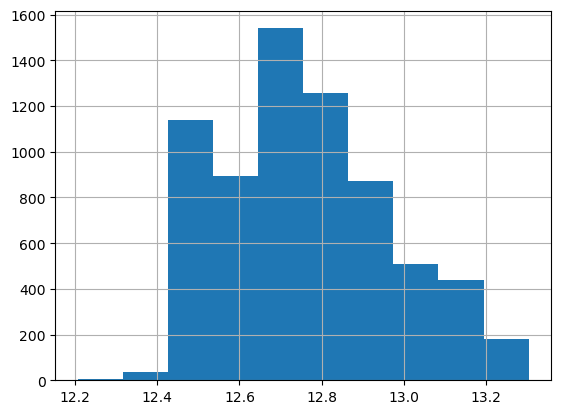

In [63]:
y_train_predict_income.hist()

In [64]:
X_train_predict_income, X_test_predict_income = mapping_first_category_plus_agegroup(X_train_predict_income, X_test_predict_income)

In [65]:
X_train_predict_income, X_test_predict_income = feature_to_int(X_train_predict_income, X_test_predict_income)

In [66]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_list = list(kf.split(X_train_predict_income, y_train_predict_income))

def train_catboost(X, y, cv, params: dict = None):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records, ))
    for i, (tr_idx, va_idx) in enumerate(cv):
        tr_x, va_x = X.iloc[tr_idx], X.iloc[va_idx]
        tr_y, va_y = y.iloc[tr_idx], y.iloc[va_idx]
        model = cb.CatBoostRegressor(**params)
        model.fit(tr_x, tr_y, eval_set=(va_x, va_y), use_best_model=True, verbose=100)
        oof_pred[va_idx] = model.predict(va_x)
        models.append(model)
    return oof_pred, models

params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'iterations': 10000,
    'learning_rate': 0.005,
    'depth': 5,
    'l2_leaf_reg': 5,    # 3 ~ 10
    'verbose': 200,
    'random_seed': 42,
}

oof, models = train_catboost(X_train_predict_income, y_train_predict_income, cv_list, params)

0:	learn: 0.2028979	test: 0.2089983	best: 0.2089983 (0)	total: 1.87ms	remaining: 18.7s
100:	learn: 0.1609477	test: 0.1648707	best: 0.1648707 (100)	total: 131ms	remaining: 12.8s
200:	learn: 0.1406098	test: 0.1435130	best: 0.1435130 (200)	total: 270ms	remaining: 13.2s
300:	learn: 0.1313831	test: 0.1341646	best: 0.1341646 (300)	total: 402ms	remaining: 13s
400:	learn: 0.1269415	test: 0.1298191	best: 0.1298191 (400)	total: 530ms	remaining: 12.7s
500:	learn: 0.1246634	test: 0.1277846	best: 0.1277846 (500)	total: 667ms	remaining: 12.7s
600:	learn: 0.1232251	test: 0.1266435	best: 0.1266435 (600)	total: 804ms	remaining: 12.6s
700:	learn: 0.1222878	test: 0.1260125	best: 0.1260125 (700)	total: 939ms	remaining: 12.5s
800:	learn: 0.1216011	test: 0.1256075	best: 0.1256075 (800)	total: 1.07s	remaining: 12.3s
900:	learn: 0.1210637	test: 0.1253090	best: 0.1253090 (900)	total: 1.2s	remaining: 12.1s
1000:	learn: 0.1205951	test: 0.1250889	best: 0.1250889 (1000)	total: 1.33s	remaining: 12s
1100:	learn: 0.1

In [67]:
y_test_predict_income = np.zeros(len(X_test_predict_income))

# アンサンブル
for model in models:
    y_test_predict_income += model.predict(X_test_predict_income) / len(models)

y_test_predict_income = pd.DataFrame({
    'MonthlyIncome': y_test_predict_income
})

In [68]:
# 訓練データとテストデータに分割する
predicted_train_age = y_test_predict_income.iloc[:len(id_train), 0]
predicted_test_age = y_test_predict_income.iloc[len(id_train): , 0]

# id(主キー)を与える。
predicted_train_age.index = id_train
predicted_test_age.index = id_test

In [69]:
df_train[2550:2560]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
2550,2550,52,Self Enquiry,1,720.0,Small Business,male,3.0,4.0,Basic,...,4.0,0,2,Executive,12.611541,1,Single,No Car,1_child,50s
2551,2551,35,Company Invited,1,960.0,Small Business,female,3.0,4.0,Basic,...,2.0,0,2,Executive,NaN,0,Divorced,Has Car,0_child,30s
2552,2552,34,Company Invited,1,1140.0,Large Business,male,3.0,3.0,Basic,...,5.0,0,2,Executive,12.644331,1,Married,No Car,1_child,30s
2553,2553,44,Self Enquiry,2,360.0,Salaried,male,3.0,4.0,Deluxe,...,5.0,1,2,AVP,13.034255,0,Divorced,Has Car,2_child,40s
2554,2554,36,Company Invited,2,780.0,Small Business,male,3.0,4.0,Standard,...,2.0,1,2,Senior Manager,12.804390,1,Married,No Car,2_child,30s
2555,2555,24,Company Invited,2,480.0,Salaried,female,2.0,4.0,Standard,...,2.0,1,1,Senior Manager,12.936554,1,Married,No Car,1_child,20s
2556,2556,37,Self Enquiry,2,1440.0,Salaried,male,3.0,4.0,Basic,...,28.0,1,2,Executive,12.611541,1,Single,No Car,2_child,30s
2557,2557,39,Company Invited,1,NaN,Salaried,male,2.0,3.0,Deluxe,...,1.0,0,4,Manager,NaN,0,Married,No Car,1_child,30s
2558,2558,31,Self Enquiry,2,1920.0,Small Business,female,3.0,3.0,Deluxe,...,2.0,0,1,Manager,12.691922,1,Single,No Car,2_child,30s
2559,2559,48,Self Enquiry,1,480.0,Large Business,female,3.0,5.0,Standard,...,6.0,0,2,Senior Manager,12.834164,0,Married,No Car,2_child,40s


In [70]:
df_test[2150:2160]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
2150,5639,48,Self Enquiry,3,1740.0,Small Business,male,3.0,4.0,Deluxe,3.0,5.0,0,3,Manager,12.845228,Divorced,No Car,1_child,40s
2151,5640,25,Self Enquiry,2,900.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,3,Executive,12.463274,Single,Has Car,1_child,20s
2152,5641,46,Self Enquiry,3,900.0,Small Business,female,3.0,4.0,Basic,3.0,5.0,0,3,Executive,12.644331,Divorced,Has Car,2_child,40s
2153,5642,44,Self Enquiry,2,960.0,Small Business,male,3.0,4.0,King,3.0,NaN,0,3,VP,12.998637,Married,Has Car,1_child,40s
2154,5643,20,Self Enquiry,2,1140.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,12.608035,Married,Has Car,1_child,20s
2155,5644,30,Self Enquiry,2,420.0,Large Business,male,3.0,4.0,Standard,3.0,12.0,0,4,Senior Manager,12.777013,Divorced,Has Car,1_child,30s
2156,5645,25,Self Enquiry,2,900.0,Salaried,male,3.0,4.0,Basic,3.0,3.0,0,4,Executive,12.650858,Single,Has Car,2_child,20s
2157,5646,30,Company Invited,2,1020.0,Small Business,male,2.0,3.0,Basic,3.0,8.0,0,4,Executive,NaN,Single,No Car,1_child,30s
2158,5647,35,Self Enquiry,1,540.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,NaN,Married,Has Car,1_child,30s
2159,5648,24,Self Enquiry,1,480.0,Small Business,female,4.0,5.0,Deluxe,4.0,3.0,0,1,Executive,12.823987,Married,No Car,2_child,20s


In [71]:
# 欠損値を予測値で補完する
df_train.loc[df_train['MonthlyIncome'].isna(), 'MonthlyIncome'] = round(predicted_train_age)
df_test.loc[df_test['MonthlyIncome'].isna(), 'MonthlyIncome'] = round(predicted_test_age)

In [72]:
df_train[2550:2560]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,ProdTaken,Marry,Car,Child,AgeGroup
2550,2550,52,Self Enquiry,1,720.0,Small Business,male,3.0,4.0,Basic,...,4.0,0,2,Executive,12.611541,1,Single,No Car,1_child,50s
2551,2551,35,Company Invited,1,960.0,Small Business,female,3.0,4.0,Basic,...,2.0,0,2,Executive,13.000000,0,Divorced,Has Car,0_child,30s
2552,2552,34,Company Invited,1,1140.0,Large Business,male,3.0,3.0,Basic,...,5.0,0,2,Executive,12.644331,1,Married,No Car,1_child,30s
2553,2553,44,Self Enquiry,2,360.0,Salaried,male,3.0,4.0,Deluxe,...,5.0,1,2,AVP,13.034255,0,Divorced,Has Car,2_child,40s
2554,2554,36,Company Invited,2,780.0,Small Business,male,3.0,4.0,Standard,...,2.0,1,2,Senior Manager,12.804390,1,Married,No Car,2_child,30s
2555,2555,24,Company Invited,2,480.0,Salaried,female,2.0,4.0,Standard,...,2.0,1,1,Senior Manager,12.936554,1,Married,No Car,1_child,20s
2556,2556,37,Self Enquiry,2,1440.0,Salaried,male,3.0,4.0,Basic,...,28.0,1,2,Executive,12.611541,1,Single,No Car,2_child,30s
2557,2557,39,Company Invited,1,NaN,Salaried,male,2.0,3.0,Deluxe,...,1.0,0,4,Manager,13.000000,0,Married,No Car,1_child,30s
2558,2558,31,Self Enquiry,2,1920.0,Small Business,female,3.0,3.0,Deluxe,...,2.0,0,1,Manager,12.691922,1,Single,No Car,2_child,30s
2559,2559,48,Self Enquiry,1,480.0,Large Business,female,3.0,5.0,Standard,...,6.0,0,2,Senior Manager,12.834164,0,Married,No Car,2_child,40s


In [73]:
df_test[2150:2160]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marry,Car,Child,AgeGroup
2150,5639,48,Self Enquiry,3,1740.0,Small Business,male,3.0,4.0,Deluxe,3.0,5.0,0,3,Manager,12.845228,Divorced,No Car,1_child,40s
2151,5640,25,Self Enquiry,2,900.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,3,Executive,12.463274,Single,Has Car,1_child,20s
2152,5641,46,Self Enquiry,3,900.0,Small Business,female,3.0,4.0,Basic,3.0,5.0,0,3,Executive,12.644331,Divorced,Has Car,2_child,40s
2153,5642,44,Self Enquiry,2,960.0,Small Business,male,3.0,4.0,King,3.0,NaN,0,3,VP,12.998637,Married,Has Car,1_child,40s
2154,5643,20,Self Enquiry,2,1140.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,12.608035,Married,Has Car,1_child,20s
2155,5644,30,Self Enquiry,2,420.0,Large Business,male,3.0,4.0,Standard,3.0,12.0,0,4,Senior Manager,12.777013,Divorced,Has Car,1_child,30s
2156,5645,25,Self Enquiry,2,900.0,Salaried,male,3.0,4.0,Basic,3.0,3.0,0,4,Executive,12.650858,Single,Has Car,2_child,20s
2157,5646,30,Company Invited,2,1020.0,Small Business,male,2.0,3.0,Basic,3.0,8.0,0,4,Executive,13.000000,Single,No Car,1_child,30s
2158,5647,35,Self Enquiry,1,540.0,Small Business,male,3.0,4.0,Basic,3.0,2.0,0,4,Executive,13.000000,Married,Has Car,1_child,30s
2159,5648,24,Self Enquiry,1,480.0,Small Business,female,4.0,5.0,Deluxe,4.0,3.0,0,1,Executive,12.823987,Married,No Car,2_child,20s


In [74]:
df_train.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           121
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              22
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
ProdTaken                   0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [75]:
df_test.isna().sum()

id                          0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch           131
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
NumberOfTrips              42
Passport                    0
PitchSatisfactionScore      0
Designation                 0
MonthlyIncome               0
Marry                       0
Car                         0
Child                       0
AgeGroup                    0
dtype: int64

In [76]:
df_train.to_csv('data/null_survey/train_age_income_ok.csv', index=False)
df_test.to_csv('data/null_survey/test_age_income_ok.csv', index=False)